# <font color='blue'>**1. Business Understanding**</font>
---

Bank XYZ is experiencing a growing number of loan defaults and must enhance its credit risk modeling to more accurately anticipate customers who might default on their loans in the future.k.

### **Business Objective**
---

The objective is to precisely detect high-risk loans, allowing for actions like raising interest rates or rejecting loan applications, ultimately leading to reduced overall risk and improved profitability for the bank.

# **<font color='Blue'>2. Imports </font>**
---

In [19]:
# Load data manipulation package
import numpy as np
import pandas as pd

# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# <font color='Blue'> **3. Importing data to Python** </font>
---

## **3.1 Import Data**
---

The sample we will use in this example is a fictive datasets from Development of Credit Risk Model & Scorecard.(https://www.kaggle.com/code/somyaagarwal69/development-of-credit-risk-model-scorecard/notebook).

We have one dataset contains the personal information of debtors and the credit performance of debtors.
We don't have the target or response variable in this sample.

Therefore, we have to assign the response variable according to our definition of 'bad' credit performance.

In [20]:
# Input csv_path
csv_path = 'loan_data_2015.csv'

# Read the CSV file with low_memory=False
data = pd.read_csv(csv_path, sep=',', low_memory=False)

# Display the shape of the DataFrame
print(data.shape)

(421094, 74)


In [21]:
# Find the sum/total of duplicated id.
data['id'].duplicated().sum()

0

There's no duplicated id in our data frame.

## **3.2 Define Bad Loan**
---

---

#### **1. Add a months-back columnn**
Create new column to define the number of months backward from the most recent month.

Variable Explanation:
- `id` : The account's unique ID.
- `issue_d` : The date the loan was issued.

In [22]:
print(data[['id','issue_d']].head)
print(data[['id','issue_d']].dtypes)

<bound method NDFrame.head of               id issue_d
0       60516983  Sep-15
1       60187139  Sep-15
2       60356453  Sep-15
3       59955769  Sep-15
4       58703693  Sep-15
...          ...     ...
421089  37257620  Jan-15
421090  35998858  Jan-15
421091  37317288  Jan-15
421092  36200493  Jan-15
421093  37011266  Jan-15

[421094 rows x 2 columns]>
id          int64
issue_d    object
dtype: object


To create a cohort table, we need to:
- **Convert "issue_d" column into datetime format.**
- **Find the Most Recent Month** : Identify the most recent month in the "issue_d" column. This reference point serves as the starting month for measuring the "months_balance."
- **Calculate Months Backward**: For each entry in the "issue_d" column, calculate the number of months backward from the most recent month. This calculation considers the difference in days between the "issue_d" date and the most recent date and then converts it into months.
- **Create a New Column**: Create a new column named "months_balance" in the DataFrame to store the calculated values.

In [23]:
# Convert "issue_d" column to datetime with format specified
data["issue_d"] = pd.to_datetime(data["issue_d"], format='%b-%y')

# Find the most recent month in the "issue_d" column
most_recent_month = data["issue_d"].max()

# Find the least recent month in the "issue_d" column
least_recent_month = data["issue_d"].min()

print("The most recent month in the 'issue_d' column is:", most_recent_month)
print("The least recent month in the 'issue_d' column is:", least_recent_month)
print(data[['id','issue_d']].dtypes)

The most recent month in the 'issue_d' column is: 2015-12-01 00:00:00
The least recent month in the 'issue_d' column is: 2015-01-01 00:00:00
id                  int64
issue_d    datetime64[ns]
dtype: object


In [24]:
# Calculate months backward from the most recent month
data["months_balance"] = (data["issue_d"] - most_recent_month).dt.days // 30

print(data[['id','months_balance']])

              id  months_balance
0       60516983              -4
1       60187139              -4
2       60356453              -4
3       59955769              -4
4       58703693              -4
...          ...             ...
421089  37257620             -12
421090  35998858             -12
421091  37317288             -12
421092  36200493             -12
421093  37011266             -12

[421094 rows x 2 columns]


Now we have a column `months_balance` : The month of the extracted data is the starting point, backwards.
- `months_balance` = `0` is the current month,
- `months_balance` = `-1` is the previous month,
- and so on.

#### **2. Define the bad loan**
---

In [25]:
# Check the data shape
data.shape

(421094, 75)

- The data contains 75 variables from 421,094 records.
- Let's check how many unique IDs we have.

In [26]:
# Check the total of unique IDs
unique_ids = data['id'].nunique()
print("Total number of unique ids:", unique_ids)

Total number of unique ids: 421094


- The data contains 421,094 unique IDs.

##### **2.1 Identify Bad Loan**

Variable Explanation:
- `id` : The account's unique ID.
- `loan_status` : The status of the loan.
  - Charged off : The borrower has not repaid the loan, and it's unlikely to be recovered
  - Default : The borrower has not met their repayment obligations, and the loan is in default
  - Late (31-120 days) : The borrower is 31 to 120 days behind on payments
  - Current : The loan is in good standing, with payments being made as agreed
  - In Grace Period : The borrower is allowed a short period for a late payment without penalties
  - Late (16-30 days) : The borrower is 16 to 30 days behind on payments
  - Issued : The loan has been approved and issued but has not yet entered the repayment phase

Re-define each loan_status :
- `0`: 1-15 days past due (Grace Period)
- `1`: 16-30 days past due (Late 16-30 days)
- `2`: 31-120 days past due (Late 31-120 days)
- `3`: 121-149 days past due (Default)
- `4`: More than 150 days past due (Charged off)
- `C`: Paid off that month (Fully paid)
- `X`: Loan is in good standing (Current)
- `I`: Loan has not yet entered the repayment phase (Issued) future.

In [27]:
# Convert each status and store to 'status_converted' column
data['status_converted'] = np.where(data['loan_status'] == 'Grace Period', 0,
                np.where(data['loan_status'] == 'Late (16-30 days)', 1,
                np.where(data['loan_status'] == 'Late (31-120 days)', 2,
                np.where(data['loan_status'] == 'Default', 3,
                np.where(data['loan_status'] == 'Charged Off', 4,
                np.where(data['loan_status'] == 'Fully Paid', 'C',
                np.where(data['loan_status'] == 'Current', 'X',
                np.where(data['loan_status'] == 'Issued', 'I', -1))))))))

print(data[['id', 'months_balance','loan_status', 'status_converted']])

              id  months_balance         loan_status status_converted
0       60516983              -4         Charged Off                4
1       60187139              -4         Charged Off                4
2       60356453              -4         Charged Off                4
3       59955769              -4         Charged Off                4
4       58703693              -4         Charged Off                4
...          ...             ...                 ...              ...
421089  37257620             -12  Late (31-120 days)                2
421090  35998858             -12  Late (31-120 days)                2
421091  37317288             -12  Late (31-120 days)                2
421092  36200493             -12  Late (31-120 days)                2
421093  37011266             -12  Late (31-120 days)                2

[421094 rows x 4 columns]


Assume that the bad loan as an account whose loan status is a minimum of 30 days past due.

In [28]:
# Define the bad loan
data['30+DPD'] = np.where(
    (data['status_converted'] == '2') |
    (data['status_converted'] == '3') |
    (data['status_converted'] == '4'),
    1,  # Set to 1 if the condition is met
    0   # Set to 0 for all other cases
)

print(data[['id','status_converted','30+DPD']])

              id status_converted  30+DPD
0       60516983                4       1
1       60187139                4       1
2       60356453                4       1
3       59955769                4       1
4       58703693                4       1
...          ...              ...     ...
421089  37257620                2       1
421090  35998858                2       1
421091  37317288                2       1
421092  36200493                2       1
421093  37011266                2       1

[421094 rows x 3 columns]


# <font color='Blue'> **4. Data Exploration** </font>
---

## **4.1 Sample Splitting**
---

Before modeling, make sure we split the data first for model validation.

In the classification case, check the proportion of the response variable first to decide the splitting strategy.

In [29]:
# Define response variable
response_variable = '30+DPD'

# Check the proportion of response variable
data[response_variable].value_counts(normalize = True)

0    0.981356
1    0.018644
Name: 30+DPD, dtype: float64

- The proportion of the response variable, `30+DPD`, is not quite balanced (in a ratio of 98:2).- To get the same ratio in training and testing set, define a stratified splitting based on the response variable, `30+DPD`

Stratified splitting ensures that when you split your dataset into training and testing sets, each set maintains the same proportion of classes as the original dataset.

First, define the predictors (X) and the response (y).

In [30]:
# Split response and predictors
y = data[response_variable]
X = data.drop(columns = [response_variable],
              axis = 1)

# Validate the splitting
print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (421094,)
X shape : (421094, 76)


Next, split the training and testing set from each predictors (X) and response (y).
- Set `stratify = y` for splitting the sample with stratify, based on the proportion of response y.
- Set `test_size = 0.3` for holding 30% of the sample as a testing set.
- Set `random_state = 42` for reproducibility.

In [31]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

# Validate splitting
print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (294765, 76)
y train shape : (294765,)
X test shape  : (126329, 76)
y test shape  : (126329,)


Check the proportion of response y in each training and testing set.

In [32]:
y_train.value_counts(normalize = True)

0    0.981355
1    0.018645
Name: 30+DPD, dtype: float64

In [33]:
y_test.value_counts(normalize = True)

0    0.981358
1    0.018642
Name: 30+DPD, dtype: float64

## **4.2 Exploratory Data Analysis**
---

- To make a model that predicts well on unseen data, we must prevent leakage of test set information.
- Thus, we only explore on **training set**

What do we do in EDA?
- Check data integrity.
- Check for any insight in the data: distribution, proportion, outliers, missing values, etc.
- Make a plan for data pre-processing..

In [34]:
# Concatenate X_train and y_train as data_train
data_train = pd.concat((X_train, y_train),
                       axis = 1)

# Validate data_train
print('Train data shape:', data_train.shape)
data_train.head()

Train data shape: (294765, 77)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,months_balance,status_converted,30+DPD
260455,49218748,52527489,6000,6000,6000,36 months,9.99,193.58,B,B3,...,NaN,NaN,NaN,8200,NaN,NaN,NaN,-8,X,0
340934,41020225,43896010,10000,10000,10000,36 months,12.29,333.53,C,C1,...,NaN,NaN,NaN,20600,NaN,NaN,NaN,-11,X,0
93453,62137052,66333818,6000,6000,6000,36 months,11.53,197.95,B,B5,...,NaN,NaN,NaN,8600,NaN,NaN,NaN,-3,X,0
115371,60945126,64986989,7500,7500,7500,36 months,13.33,253.90,C,C3,...,NaN,NaN,NaN,10000,NaN,NaN,NaN,-3,X,0
358582,39560580,42384347,14000,14000,14000,60 months,8.67,288.38,B,B1,...,NaN,NaN,NaN,16000,NaN,NaN,NaN,-12,X,0


### Check for Missing Values
---

In [35]:
# Check for missing values
data_train.isna().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
total_cu_tl         279871
inq_last_12m        279871
months_balance           0
status_converted         0
30+DPD                   0
Length: 77, dtype: int64

In [36]:
# Check for data type
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294765 entries, 260455 to 254455
Data columns (total 77 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           294765 non-null  int64         
 1   member_id                    294765 non-null  int64         
 2   loan_amnt                    294765 non-null  int64         
 3   funded_amnt                  294765 non-null  int64         
 4   funded_amnt_inv              294765 non-null  int64         
 5   term                         294765 non-null  object        
 6   int_rate                     294765 non-null  float64       
 7   installment                  294765 non-null  float64       
 8   grade                        294765 non-null  object        
 9   sub_grade                    294765 non-null  object        
 10  emp_title                    278094 non-null  object        
 11  emp_length           

**Summary**
- There are missing values in more than 10 variables.
- Considering the large number of columns in our dataset with missing data, it's a wise choice to filter or remove columns where more than 80% of the data is missing.
- This action eliminates unreliable or irrelevant features and reduces the dataset's complexity, enhancing the performance of machine learning models, and optimizes how our computer resources are used.




In [37]:
# Get a list of columns with more than 80% null values
null_threshold = 0.80  # Define the threshold

# Calculate the percentage of null values in each column
null_percentages = data_train.isnull().mean()

# Filter columns with more than 80% null values
columns_with_high_nulls = null_percentages[null_percentages > null_threshold]

# Display the list of columns and their null percentages
print("Columns with more than 80% null values:")
for column, percentage in columns_with_high_nulls.items():
    print(f"{column}: {percentage:.2%}")

Columns with more than 80% null values:
desc: 99.99%
mths_since_last_record: 82.36%
annual_inc_joint: 99.88%
dti_joint: 99.88%
verification_status_joint: 99.88%
open_acc_6m: 94.95%
open_il_6m: 94.95%
open_il_12m: 94.95%
open_il_24m: 94.95%
mths_since_rcnt_il: 95.08%
total_bal_il: 94.95%
il_util: 95.59%
open_rv_12m: 94.95%
open_rv_24m: 94.95%
max_bal_bc: 94.95%
all_util: 94.95%
inq_fi: 94.95%
total_cu_tl: 94.95%
inq_last_12m: 94.95%


In [38]:
# Drop columns with more than 80% null values
columns_to_drop = [col for col in columns_with_high_nulls.index if col in data_train.columns]
data_train.drop(columns=columns_to_drop, inplace=True)

# Display the DataFrame after dropping columns
print("\nDataFrame after dropping columns:")
print(data_train.shape)


DataFrame after dropping columns:
(294765, 58)


In [39]:
# Check for missing values
data_train.isna().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       16671
emp_length                      16641
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
purpose                             0
title                              90
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         0
earliest_cr_line                    0
inq_last_6mt

In [40]:
# Identify columns with missing values
columns_with_missing_values = data_train.columns[data_train.isnull().sum() > 0]
print(columns_with_missing_values)

Index(['emp_title', 'emp_length', 'title', 'mths_since_last_delinq',
       'revol_util', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
       'mths_since_last_major_derog'],
      dtype='object')


- Currently, 6 variables contain missing values.
- Ideally, each one requires in-depth exploration to decide on the appropriate approach for handling these gaps.
- Nevertheless, due to time limitations and taking into account the significance and definitions of these variables,
  we will focus on a detailed analysis of 1 variable (`emp_length`), while the remaining 5 will be removed from consideration.

After careful considerations, we will only use 6 numerical & 3categorical columns as predictors

In [41]:
# Define data with categorical predictors
# Let's keep only 2 categorical predictors
cat_columns = ['grade',
               'home_ownership',
               'purpose']

In [42]:
# Define data with numerical predictors
# Let's keep only 6 numerical predictors
num_columns = data_train[['loan_amnt',
                            'term',
                            'int_rate',
                            'emp_length',
                            'annual_inc',
                            'dti']]

In [43]:
selected_columns = ['grade', 'home_ownership', 'purpose', 'loan_amnt', 'term', 'int_rate', 'emp_length', 'annual_inc', 'dti', '30+DPD']
data_train_filtered = data_train[selected_columns]
print(data_train_filtered)

       grade home_ownership             purpose  loan_amnt        term  \
260455     B       MORTGAGE  debt_consolidation       6000   36 months   
340934     C       MORTGAGE         credit_card      10000   36 months   
93453      B           RENT         credit_card       6000   36 months   
115371     C       MORTGAGE  debt_consolidation       7500   36 months   
358582     B       MORTGAGE         credit_card      14000   60 months   
...      ...            ...                 ...        ...         ...   
19429      C           RENT    home_improvement      16000   36 months   
35779      C           RENT               other       1400   36 months   
388181     E       MORTGAGE  debt_consolidation      14550   36 months   
342413     C           RENT  debt_consolidation       8000   36 months   
254455     C       MORTGAGE  debt_consolidation      11000   36 months   

        int_rate emp_length  annual_inc    dti  30+DPD  
260455      9.99     1 year    120000.0  15.98       0

### Predictor 1 : emp_length
---

In [44]:
# Descriptive statistics of 'emp_length'
data_train_filtered['emp_length'].describe()

count        278124
unique           11
top       10+ years
freq          98983
Name: emp_length, dtype: object

In [45]:
data_train_filtered['emp_length'].head()

260455       1 year
340934    10+ years
93453        1 year
115371    10+ years
358582      7 years
Name: emp_length, dtype: object

We need to clean up the 'emp_length' column by :
- removing certain text characters,
- converting the values to numeric,
- assigning a value of 0 to any NaN (Not-a-Number) values.

In [46]:
# # Helper function to clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(data_train_filtered, emp_length):
    # Create a copy of the column to avoid modifying the original DataFrame
    emp_length_column = data_train_filtered[emp_length].copy()
    
    # Ensure the column contains string values
    emp_length_column = emp_length_column.astype(str)
    
    # Clean up the text in the emp_length
    emp_length_column = emp_length_column.str.replace(r'[^0-9]', '', regex=True)
    
    # Convert to numeric
    emp_length_column = pd.to_numeric(emp_length_column, errors='coerce')
    
    # Fill NaN values with 0
    emp_length_column.fillna(value=0, inplace=True)
    
    # Assign the modified column back to the original DataFrame
    data_train_filtered[emp_length] = emp_length_column


In [47]:
# Descriptive statistics of 'emp_length'
data_train_filtered['emp_length'].describe()

count        278124
unique           11
top       10+ years
freq          98983
Name: emp_length, dtype: object

- On average, our debtors have an employment length of 5.7 years, with the shortest being 'unemployed' and the longest being 10 years.

<Axes: xlabel='emp_length', ylabel='Count'>

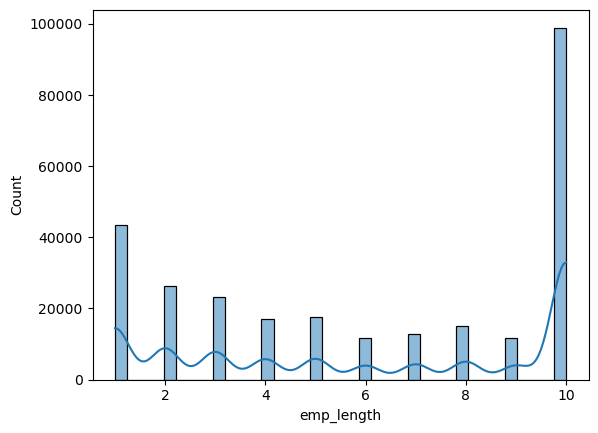

In [98]:
# Distribution plot of 'emp_length'
sns.histplot(data = data_train_filtered,
             x = 'emp_length',
             kde = True)

But we have a left-skewed distribution (negatively skewed), where most of our debtors are around 5.7 years

In [49]:
# Descriptive of 'emp_length' by response variable
data_train_filtered['emp_length'].groupby(data_train_filtered['30+DPD']).describe()

,count,unique,top,freq
30+DPD,,,,
0,272990,11,10+ years,97405
1,5134,11,10+ years,1578


<Axes: xlabel='30+DPD', ylabel='emp_length'>

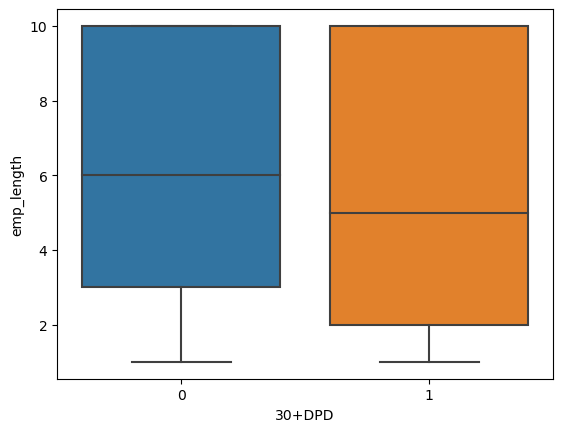

In [99]:
# Boxplot of 'emp_length' by response variable
sns.boxplot(data = data_train_filtered,
            x = '30+DPD',
            y = 'emp_length')

We can see the bad accounts come from all length of employment of the borrower.

## **4.3 Check Correlation**
---

We will check the Pearson correlation between numerical predictors to see whether we have multicollinearity in training set.

In [51]:
# Check for data type
data_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294765 entries, 260455 to 254455
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   grade           294765 non-null  object 
 1   home_ownership  294765 non-null  object 
 2   purpose         294765 non-null  object 
 3   loan_amnt       294765 non-null  int64  
 4   term            294765 non-null  object 
 5   int_rate        294765 non-null  float64
 6   emp_length      278124 non-null  object 
 7   annual_inc      294765 non-null  float64
 8   dti             294765 non-null  float64
 9   30+DPD          294765 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 24.7+ MB


In [52]:
# Calculate Pearson correlation coefficient from numerical predictors
data_train_filtered_corr = num_columns.corr(method='pearson', numeric_only=True)

data_train_filtered_corr

,loan_amnt,int_rate,annual_inc,dti
loan_amnt,1.000000,0.142390,0.317137,0.005103
int_rate,0.142390,1.000000,-0.091224,0.066347
annual_inc,0.317137,-0.091224,1.000000,-0.060846
dti,0.005103,0.066347,-0.060846,1.000000


<Axes: >

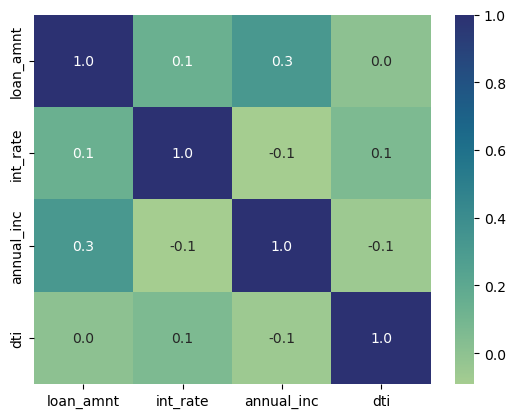

In [53]:
# Plot the heatmap correlation
sns.heatmap(data = data_train_filtered_corr,
            cmap = 'crest',
            annot = True,
            fmt = '.1f')

There's no sign of multicollinearity

# <font color='Blue'> **5. Initial Characteristic Analysis** </font>
---

## **5.1 Characteristic Binning**

Create a function for binning the numerical predictors.

In [54]:
data_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294765 entries, 260455 to 254455
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   grade           294765 non-null  object 
 1   home_ownership  294765 non-null  object 
 2   purpose         294765 non-null  object 
 3   loan_amnt       294765 non-null  int64  
 4   term            294765 non-null  object 
 5   int_rate        294765 non-null  float64
 6   emp_length      278124 non-null  object 
 7   annual_inc      294765 non-null  float64
 8   dti             294765 non-null  float64
 9   30+DPD          294765 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 24.7+ MB


In [55]:
# Convert dtype of `emp_length` and `term`

# Ensure the column contains string values
data_train_filtered['emp_length'] = data_train_filtered['emp_length'].astype(str)

# Clean up the text in the emp_length
data_train_filtered['emp_length'] = data_train_filtered['emp_length'].str.replace(r'[^0-9]', '', regex=True)

# Convert to numeric
data_train_filtered['emp_length'] = pd.to_numeric(data_train_filtered['emp_length'], errors='coerce')

# Ensure the column contains string values
data_train_filtered['term'] = data_train_filtered['term'].astype(str)

# Clean up the text in the term column to keep only numeric characters
data_train_filtered['term'] = data_train_filtered['term'].str.replace(r'[^0-9]', '', regex=True)

# Convert to numeric
data_train_filtered['term'] = pd.to_numeric(data_train_filtered['term'], errors='coerce')


/tmp/ipykernel_5384/2380323272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_filtered['emp_length'] = data_train_filtered['emp_length'].astype(str)
/tmp/ipykernel_5384/2380323272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_filtered['emp_length'] = data_train_filtered['emp_length'].str.replace(r'[^0-9]', '', regex=True)
/tmp/ipykernel_5384/2380323272.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [56]:
data_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294765 entries, 260455 to 254455
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   grade           294765 non-null  object 
 1   home_ownership  294765 non-null  object 
 2   purpose         294765 non-null  object 
 3   loan_amnt       294765 non-null  int64  
 4   term            294765 non-null  int64  
 5   int_rate        294765 non-null  float64
 6   emp_length      278124 non-null  float64
 7   annual_inc      294765 non-null  float64
 8   dti             294765 non-null  float64
 9   30+DPD          294765 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 24.7+ MB


In [57]:
# Create a function for binning the numerical predictor
def create_binning(data, predictor_label, num_of_bins):
    """
    Function for binning a numerical predictor.

    Parameters
    ----------
    data : DataFrame
      The dataset.

    predictor_label : str
      The label of the predictor variable.

    num_of_bins : int
      The number of bins.

    Returns
    ------
    data : DataFrame
      The transformed dataset.
    """
    # Create a new column containing the binned predictor
    data.loc[:, predictor_label + "_bin"] = pd.qcut(data[predictor_label], q=num_of_bins, duplicates='drop')

    return data

In [58]:
# Loop through numerical columns and apply the binning function
for column in num_columns:
    data_train_filtered_binned = create_binning(data=data_train_filtered, predictor_label=column, num_of_bins=4)

/tmp/ipykernel_5384/1523649247.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, predictor_label + "_bin"] = pd.qcut(data[predictor_label], q=num_of_bins, duplicates='drop')
/tmp/ipykernel_5384/1523649247.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, predictor_label + "_bin"] = pd.qcut(data[predictor_label], q=num_of_bins, duplicates='drop')
/tmp/ipykernel_5384/1523649247.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [59]:
data_train_filtered_binned.T

,260455,340934,93453,115371,358582,291043,41932,359602,349732,180728,...,282696,245566,389863,169883,177514,19429,35779,388181,342413,254455
grade,B,C,B,C,B,B,B,C,A,B,...,B,B,F,D,B,C,C,E,C,C
home_ownership,MORTGAGE,MORTGAGE,RENT,MORTGAGE,MORTGAGE,RENT,MORTGAGE,RENT,MORTGAGE,RENT,...,RENT,MORTGAGE,MORTGAGE,MORTGAGE,RENT,RENT,RENT,MORTGAGE,RENT,MORTGAGE
purpose,debt_consolidation,credit_card,credit_card,debt_consolidation,credit_card,moving,other,debt_consolidation,debt_consolidation,credit_card,...,debt_consolidation,credit_card,credit_card,credit_card,debt_consolidation,home_improvement,other,debt_consolidation,debt_consolidation,debt_consolidation
loan_amnt,6000,10000,6000,7500,14000,4000,10000,6000,15200,15000,...,24000,25000,35000,17500,3000,16000,1400,14550,8000,11000
term,36,36,36,36,60,36,36,36,36,36,...,60,60,60,60,36,36,36,36,36,36
int_rate,9.99,12.29,11.53,13.33,8.67,11.53,10.99,14.99,6.99,9.17,...,9.17,10.99,25.57,15.61,9.99,12.59,11.99,18.25,12.69,12.69
emp_length,1.0,10.0,1.0,10.0,7.0,1.0,1.0,1.0,10.0,3.0,...,1.0,3.0,8.0,1.0,10.0,10.0,6.0,10.0,1.0,8.0
annual_inc,120000.0,37500.0,25855.0,45000.0,80000.0,34000.0,50000.0,24000.0,125600.0,68000.0,...,76500.0,147000.0,200000.0,35000.0,65000.0,65000.0,42000.0,40000.0,50000.0,50000.0
dti,15.98,26.27,20.01,25.71,16.24,18.92,30.51,28.65,16.91,16.91,...,9.19,12.86,26.86,32.2,25.46,23.99,8.45,34.26,37.37,38.65
30+DPD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **5.2 WoE and IV**

To assess the strength of each characteristic individually as a predictor of the credit performance.

First, create a contingency table/crosstab for all predictors: numerical and categorical predictors.

In [76]:
# Define the initial empty list
crosstab_num = []

for column in num_columns:

  # Create a contingency table
  crosstab = pd.crosstab(data_train_filtered_binned[column + "_bin"],
                         data_train_filtered_binned[response_variable],
                         margins = True)

  # Append to the list
  crosstab_num.append(crosstab)

In [77]:
# Define the initial empty list
crosstab_cat = []

for column in cat_columns:

  # Create a contingency table
  crosstab = pd.crosstab(data_train_filtered_binned[column],
                         data_train_filtered_binned[response_variable],
                         margins = True)

  # Append to the list
  crosstab_cat.append(crosstab)

In [79]:
# Put all two in a crosstab_list
crosstab_list = crosstab_num + crosstab_cat

crosstab_list

[30+DPD                   0     1     All
 loan_amnt_bin                           
 (999.999, 8500.0]    72659  1318   73977
 (8500.0, 14000.0]    74727  1472   76199
 (14000.0, 20000.0]   71251  1359   72610
 (20000.0, 35000.0]   70632  1347   71979
 All                 289269  5496  294765,
 30+DPD               0     1     All
 term_bin                            
 (35.999, 60.0]  289269  5496  294765
 All             289269  5496  294765,
 30+DPD               0     1     All
 int_rate_bin                        
 (5.319, 9.17]    80590   339   80929
 (9.17, 12.29]    68435   753   69188
 (12.29, 15.59]   69616  1367   70983
 (15.59, 28.99]   70628  3037   73665
 All             289269  5496  294765,
 30+DPD               0     1     All
 emp_length_bin                      
 (0.999, 2.0]     68203  1474   69677
 (2.0, 6.0]       68394  1351   69745
 (6.0, 10.0]     136393  2309  138702
 All             272990  5134  278124,
 30+DPD                     0     1     All
 annual_inc_

Next, calculate the WOE and IV for each crosstab.

- Weight of Evidence (WoE) — measures the strength of each attribute.

$$
\begin{align*}
W_i &= \ln ( \% \text{Good} / \% \text{Bad} ) \\
W_i &= \ln \left ( \left ( \frac{N_i}{\sum N} \right ) / \left ( \frac{P_i}{\sum P} \right )\right ) \\
\end{align*}
$$

- Information Value (IV) — measures the total strength of the characteristic.

$$
\begin{align*}
IV &= \sum_{i=1}^{n} ( \% \text{Good} - \% \text{Bad} ) \times W_i \\
IV &= \sum_{i=1}^{n}\left [ \left ( \frac{N_i}{\sum N} - \frac{P_i}{\sum P} \right ) \times W_i \right ] \\
\end{align*}
$$

In [80]:
# Define the initial list for WOE
WOE_list = []

# Define the initial list for IV
IV_list = []

# Create the initial table for IV
IV_table = pd.DataFrame({'Characteristic': [],
                         'Information Value' : []})

# Perform the algorithm for all crosstab
for crosstab in crosstab_list:

  # Calculate % Good
    crosstab['p_good'] = crosstab[0]/crosstab[0]['All']

  # Calculate % Bad
    crosstab['p_bad'] = crosstab[1]/crosstab[1]['All']

  # Calculate the WOE
    crosstab['WOE'] = np.log((crosstab['p_good'] + 1e-10) / (crosstab['p_bad'] + 1e-10))

  # Calculate the contribution value for IV
    crosstab['contribution'] = (crosstab['p_good']-crosstab['p_bad'])*crosstab['WOE']

  # Calculate the IV
    IV = crosstab['contribution'][:-1].sum()
    
    add_IV = {'Characteristic': crosstab.index.name,
            'Information Value': IV}
    
    WOE_list.append(crosstab)
    IV_list.append(add_IV)

In [81]:
WOE_list

[30+DPD                   0     1     All    p_good     p_bad       WOE  \
 loan_amnt_bin                                                            
 (999.999, 8500.0]    72659  1318   73977  0.251181  0.239811  0.046325   
 (8500.0, 14000.0]    74727  1472   76199  0.258330  0.267831 -0.036117   
 (14000.0, 20000.0]   71251  1359   72610  0.246314  0.247271 -0.003877   
 (20000.0, 35000.0]   70632  1347   71979  0.244174  0.245087 -0.003733   
 All                 289269  5496  294765  1.000000  1.000000  0.000000   
 
 30+DPD              contribution  
 loan_amnt_bin                     
 (999.999, 8500.0]       0.000527  
 (8500.0, 14000.0]       0.000343  
 (14000.0, 20000.0]      0.000004  
 (20000.0, 35000.0]      0.000003  
 All                     0.000000  ,
 30+DPD               0     1     All  p_good  p_bad  WOE  contribution
 term_bin                                                              
 (35.999, 60.0]  289269  5496  294765     1.0    1.0  0.0           0.0
 All

In [82]:
# Put all IV in the table
IV_table = pd.concat([IV_table, pd.DataFrame(IV_list)], ignore_index=True)
IV_table

,Characteristic,Information Value
0,loan_amnt_bin,0.000877
1,term_bin,0.000000
2,int_rate_bin,0.633636
3,emp_length_bin,0.011047
4,annual_inc_bin,0.033892
5,dti_bin,0.044300
6,grade,0.661237
7,home_ownership,0.043907
8,purpose,0.066179


The rule of thumb regarding IV:
- Less than 0.02 : generally unpredictive
- 0.02 to 0.1 : weak
- 0.1 to 0.3 : medium
- 0.3+ : strong

In [83]:
# Define the predictive power of each characteristic
strength = []

# Assign the rule of thumb regarding IV
for iv in IV_table['Information Value']:
  if iv < 0.02:
    strength.append('Unpredictive')
  elif iv >= 0.02 and iv < 0.1:
    strength.append('Weak')
  elif iv >= 0.1 and iv < 0.3:
    strength.append('Medium')
  else:
    strength.append('Strong')

# Assign the strength to each characteristic
IV_table = IV_table.assign(Strength = strength)

# Sort the table by the IV values
IV_table.sort_values(by='Information Value')

,Characteristic,Information Value,Strength
1,term_bin,0.000000,Unpredictive
0,loan_amnt_bin,0.000877,Unpredictive
3,emp_length_bin,0.011047,Unpredictive
4,annual_inc_bin,0.033892,Weak
7,home_ownership,0.043907,Weak
5,dti_bin,0.044300,Weak
8,purpose,0.066179,Weak
2,int_rate_bin,0.633636,Strong
6,grade,0.661237,Strong


We have 3 unpredictive and 4 weak characteristics.

Before performing model selection in modeling, we will check the independency between each characteristic with the response variable `30+DPD`.

Before that, we'll check the logical trend and operational/business considerations from the WOE in each characteristic.

### **5.3 Check Logical Trend and Business Consideration**
---

In grouped scorecards, the attribute strengths must also be in a logical order, and make operational sense.

In [84]:
# Create a funtion to plot the WOE
def plot_WOE(crosstab):
  """
  Function to plot the WOE trend.

  Parameters
  ----------
  crosstab : DataFrame
    The cross tabulation of the characteristic.

  """
  # Define the plot size
  plt.figure(figsize = (8,4))

  # Plot the WOE
  sns.pointplot(x = crosstab.T.columns,
                y = 'WOE',
                data = crosstab,
                markers = 'o',
                linestyles = '--',
                color = 'blue')

  # Rotate the label of x-axis
  plt.xticks(rotation = 20)


#### Characteristic 1: emp_length_bin
---

In [85]:
# Define the crosstab
crosstab_emp_length_bin = crosstab_list[0]

crosstab_emp_length_bin

30+DPD,0,1,All,p_good,p_bad,WOE,contribution
loan_amnt_bin,,,,,,,
"(999.999, 8500.0]",72659,1318,73977,0.251181,0.239811,0.046325,0.000527
"(8500.0, 14000.0]",74727,1472,76199,0.258330,0.267831,-0.036117,0.000343
"(14000.0, 20000.0]",71251,1359,72610,0.246314,0.247271,-0.003877,0.000004
"(20000.0, 35000.0]",70632,1347,71979,0.244174,0.245087,-0.003733,0.000003
All,289269,5496,294765,1.000000,1.000000,0.000000,0.000000


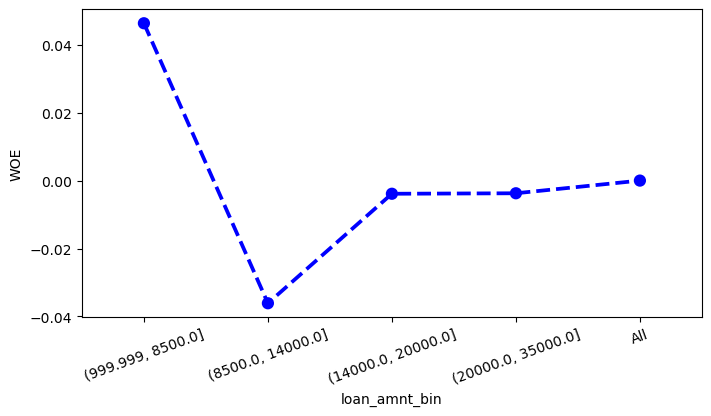

In [86]:
# Plot the WOE
plot_WOE(crosstab_emp_length_bin)

#### Characteristic 2: loan_amnt_bin
---

In [87]:
# Define the crosstab
crosstab_loan_amnt = crosstab_list[0]

crosstab_loan_amnt

30+DPD,0,1,All,p_good,p_bad,WOE,contribution
loan_amnt_bin,,,,,,,
"(999.999, 8500.0]",72659,1318,73977,0.251181,0.239811,0.046325,0.000527
"(8500.0, 14000.0]",74727,1472,76199,0.258330,0.267831,-0.036117,0.000343
"(14000.0, 20000.0]",71251,1359,72610,0.246314,0.247271,-0.003877,0.000004
"(20000.0, 35000.0]",70632,1347,71979,0.244174,0.245087,-0.003733,0.000003
All,289269,5496,294765,1.000000,1.000000,0.000000,0.000000


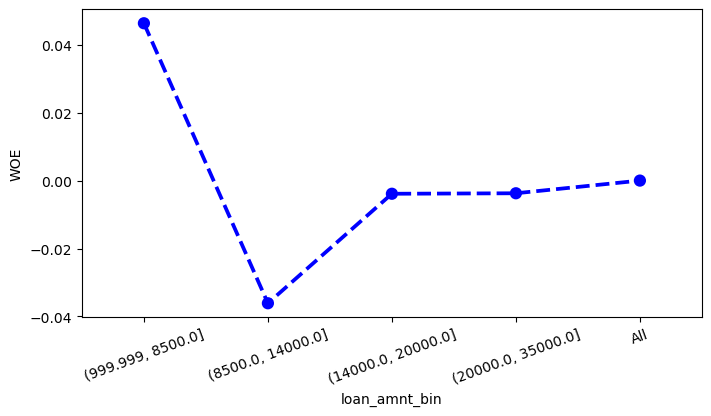

In [71]:
# Plot the WOE
plot_WOE(crosstab_loan_amnt)

The medium loan amount category has a slightly lower risk of default compared to the other categories

#### Characteristic 3: term_bin
---

In [88]:
# Define the crosstab
crosstab_term_bin = crosstab_list[0]

crosstab_term_bin

30+DPD,0,1,All,p_good,p_bad,WOE,contribution
loan_amnt_bin,,,,,,,
"(999.999, 8500.0]",72659,1318,73977,0.251181,0.239811,0.046325,0.000527
"(8500.0, 14000.0]",74727,1472,76199,0.258330,0.267831,-0.036117,0.000343
"(14000.0, 20000.0]",71251,1359,72610,0.246314,0.247271,-0.003877,0.000004
"(20000.0, 35000.0]",70632,1347,71979,0.244174,0.245087,-0.003733,0.000003
All,289269,5496,294765,1.000000,1.000000,0.000000,0.000000


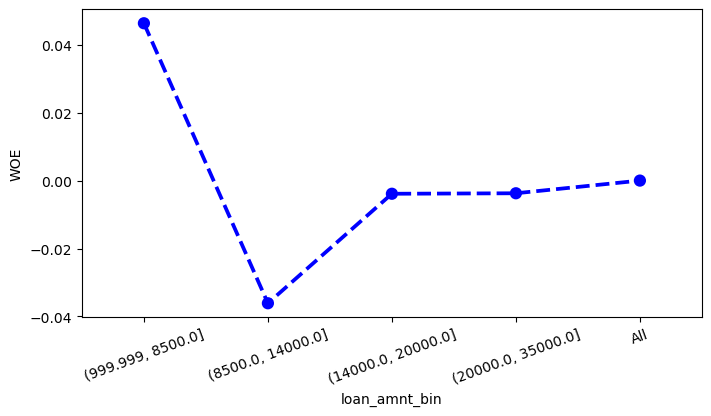

In [89]:
# Plot the WOE
plot_WOE(crosstab_term_bin)

### **5.4 Test of Independence**
---

- Assume that the WOE for each attribute in all characteristics supports the logical trend and operational/business sense.
- Then, we can check the strength of each characteristic as a predictor of credit performance by its Information Value (IV).

In [91]:
# Display the IV Table
IV_table

,Characteristic,Information Value,Strength
0,loan_amnt_bin,0.000877,Unpredictive
1,term_bin,0.000000,Unpredictive
2,int_rate_bin,0.633636,Strong
3,emp_length_bin,0.011047,Unpredictive
4,annual_inc_bin,0.033892,Weak
5,dti_bin,0.044300,Weak
6,grade,0.661237,Strong
7,home_ownership,0.043907,Weak
8,purpose,0.066179,Weak


The predictive power of characteristics varies from unpredictive to strong.

Next, we check the dependency between each characteristic and the response variable `30+DPD` before modeling.
- To check whether the unpredictive and weak characteristic is independent of the probability of default.

In [93]:
# Define a list of all characteristics
characteristic_list = IV_table['Characteristic']

Create a funtion to perform independence test.

- **Null Hypothesis:** The characteristic and response variable is independent.
- **Alternative Hypothesis:** The characteristic and response variable is not independent.
- **Test Statistic:**
  - Pearson Chi-squared Statistic

  $$
  \chi ^{2}=\sum \frac{(n_{ij}-\mu _{ij})^{2}}{\mu _{ij}}
  $$
  where
  $$
  \mu _{ij}=\frac{(n_{i+})(n_{+j})}{n}
  $$

  - degrees of freedom = $(I-1) \times (J-1)$
- **Rejection Region:**

$$
\begin{align*}
\chi^{2} &> \chi^{2}_{\alpha} \\
&\text{or} \\
P_{\text{value}} &< \alpha
\end{align*}
$$


In [95]:
# Import the libraries
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Create a function of independence test
def independence_test(data, characteristic_label, alpha=0.05):
    """
    Funtion to perform the independence test.

    Parameters
    ----------
    data : array like
      The name of dataset.

    characteristic_label : object
      The label of characteristic variable.

    alpha : float in range[0,1], default = 0.05
      Probability of Type I Error (reject H0 when H0 is true).

    Return
    ------
    res : dataframe
      The summary result of the independence test.

    """
    # Build the contingency table
    crosstab = pd.crosstab(data[characteristic_label],
                           data[response_variable],
                           margins = False)

    # Test whether churn is independent of the predictor
    stats.chi2_contingency(crosstab)

    # Result of independence test
    result = stats.chi2_contingency(crosstab)

    # Extract the test result
    stat = result[0]
    pval = result[1]

    # Print the conclusion
    if pval < alpha:
        conclusion = 'Not Independent'
    else:
        conclusion = 'Independent'

    # Tabulate the results
    res = pd.DataFrame({'Characteristic': characteristic_label,
                        'Chi-stat': round(stat,2),
                        'P-value': pval,
                        'Conclusion': conclusion},
                       index=[0])

    return res

In [97]:
# Define initial table to summarize the test result
ind_table = pd.DataFrame({'Characteristic': [],
                        'Chi-stat': [],
                        'P-value': [],
                        'Conclusion': []})

# Define initial list to store the test result
independence_list = []

# Perform independence test for all characteristics
for characteristic in characteristic_list:

  # Perform the independence test
  test_result = independence_test(data = data_train_filtered_binned,
                                  characteristic_label = characteristic,
                                  alpha = 0.05)

  # Append test result to the list
  independence_list.append(test_result)

# Append the list of test results to the table
ind_table = ind_table.append(independence_list,
                             ignore_index = True)
ind_table

/tmp/ipykernel_5384/1920831478.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ind_table = ind_table.append(independence_list,


,Characteristic,Chi-stat,P-value,Conclusion
0,loan_amnt_bin,4.70,1.951055e-01,Independent
1,term_bin,0.00,1.000000e+00,Independent
2,int_rate_bin,3206.58,0.000000e+00,Not Independent
3,emp_length_bin,56.27,6.028864e-13,Not Independent
4,annual_inc_bin,184.84,7.963236e-40,Not Independent
5,dti_bin,255.90,3.458077e-55,Not Independent
6,grade,3869.12,0.000000e+00,Not Independent
7,home_ownership,236.68,4.970555e-51,Not Independent
8,purpose,368.61,9.354184e-71,Not Independent


- Of all characteristics, there are 3 characteristics that is independent of the response variable (probability of default).
- This information can be valuable for understanding which factors may influence the likelihood of default in the dataset.